<a href="https://colab.research.google.com/github/appletreeleaf/Study_Log/blob/Linear_Algebra/%5BHW9%5D_SVD_%EC%9D%B4%EC%9E%AC%EC%98%81.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **[HW9] Practice_7**
1. Install packages
2. Geometry of SVD
3. SVD in higher dimensions
4. Image compression
5. Non-square matrix

선형대수 실습은, exercise 혹은 coding 문제풀이에 집중하기 보다는, 수업시간에 배웠던 개념들을 visualize 하면서 이를 폭넓게 이해하는 데에 초점을 맞추고 있습니다. 실습에서 사용한 예시 외에도, 다양한 matrix들을 visualize 하면서 개념을 익혀보시기 바랍니다.

# 1. Install packages

> 필요한 package를 설치하고 import합니다

In [ ]:
# visualization을 위한 helper code입니다.
from urllib.request import urlretrieve
URL = 'https://go.gwu.edu/engcomp4plot'
urlretrieve(URL, 'plot_helper.py')

import sys
sys.path.append('../scripts/')

# 다음 세 custom function (1)plot_vector, (2)plot_linear_transformation, (3) plot_linear_transformations
# 을 사용할 것입니다.
from plot_helper import *

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import scipy as sp
import scipy.linalg
import sympy as sy

sy.init_printing()
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

# 2. Geometry of SVD

> Singular value decomposition(SVD)은 eigendecomposition과 마찬가지로 matrix decomposition 방법 중 하나입니다. SVD는 dimensionality reduction, low-rank matrix approximation, recommendation system 등 다양한 분야에 사용됩니다.

## Symmetric square matrix

> [HW7] Practice_5에서, 우리는 $B = \begin{bmatrix} 1 & 0 \\ 1 & 3 \end{bmatrix}$을 eigendecompose 했습니다.

[3. 1.]
[[ 0.     0.894]
 [ 1.    -0.447]]


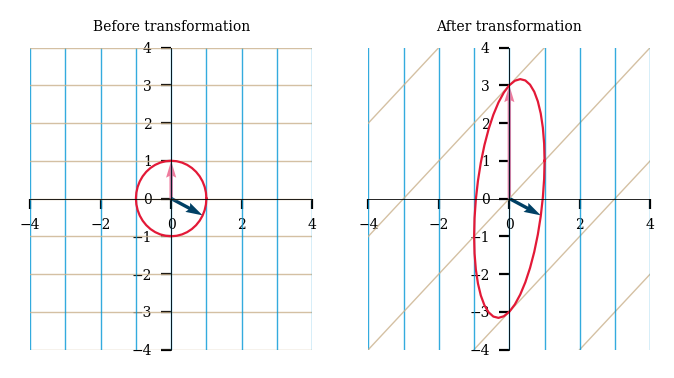

In [ ]:
B = np.array([[1,0],[1,3]]) #행방향으로 넣는구나
eigenvalues_B, eigenvectors_B = np.linalg.eig(B)
print(eigenvalues_B)
print(eigenvectors_B)
plot_linear_transformation(B, eigenvectors_B[:,0], eigenvectors_B[:,1], unit_vector=False, unit_circle=True)

> $B$가 symmetric matrix가 아니기 때문에, 두 eigenvectors $ev_1, ev_2$는 타원의 major axis (장축), minor axis (단축) 위에 있지 않게 됩니다. 즉, 여전히 $B$는

$$ eigenvalues = s_1, s_2 \\
B\begin{bmatrix}    \mid & \mid \\    \mathbf{ev_1} & \mathbf{ev_2}\\    \mid & \mid    \end{bmatrix} =  \begin{bmatrix}  \mid & \mid \\  \mathbf{ev_1} & \mathbf{ev_2} \\  \mid & \mid \end{bmatrix} \begin{bmatrix} s_1 & 0 \\ 0 & s_2 \end{bmatrix} \\
BP = PD \\
B = PDP^{-1}$$

> 을 만족하지만, $ev_1$과 $ev_2$는 수직하지 않습니다 (symmetric matrix의 경우 eigenvector를 수직하게 만들 수 있음은 지난 강의와 실습 때 배웠습니다).

> 그럼 지금 위 타원의 major axis, minor axis의 vector는 무엇이며, 어떻게 작동하고 있을까요?

In [ ]:
alpha = np.linspace(0, 2*np.pi, 201)
circle = np.vstack((np.cos(alpha), np.sin(alpha)))  # 왼쪽 그림의 원
ellipse = B @ circle  # 오른쪽 그림의 타원

distance = np.linalg.norm(ellipse, axis=0) # 벡터들의 길이를 담은 이중리스트
semi_major_id = np.argmax(distance) # 장축 vector의 idx
semi_minor_id = np.argmin(distance) # 단축 vector의 idx
semi_major = ellipse[:, semi_major_id]  # 장축 vector
semi_minor = ellipse[:, semi_minor_id]  # 단축 vector
print(semi_major, np.linalg.norm(semi_major))  # 장축길이/2
print(semi_minor, np.linalg.norm(semi_minor))  # 단축길이/2

[0.339 3.161] 3.1794761076254896
[-0.941  0.075] 0.943891774007311


> 오른쪽 그림의 major axis의 vector는 $\begin{bmatrix} 0.339  \\  3.161 \end{bmatrix}$, $\begin{bmatrix} -0.941 \\ 0.075 \end{bmatrix}$ 임을 알 수 있습니다 (위의 eigenvector와 다른것을 확인할 수 있습니다). 이 두 vector는, 왼쪽 그림의 원 중 어느 vector가 transform된 것일까요?

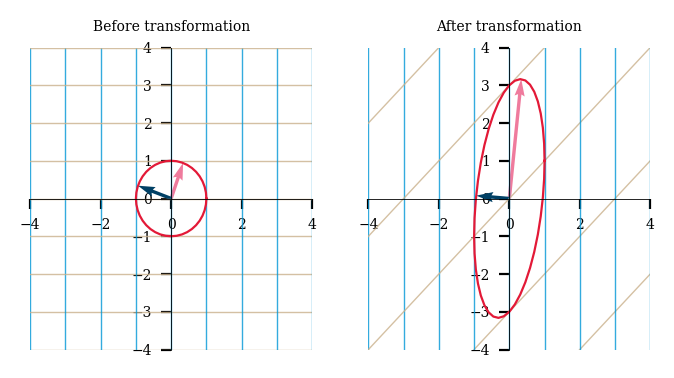

In [ ]:
B_inv = np.linalg.inv(B)
semi_major_before = B_inv @ semi_major
semi_minor_before = B_inv @ semi_minor
plot_linear_transformation(B, semi_major_before, semi_minor_before, unit_vector=False, unit_circle=True)

In [ ]:
semi_major_before @ semi_minor_before

> 놀랍게도, 단축vector와 장축 vector가 $B$에 의해 옮겨지기 전 두 vector는 서로 orthogonal함을 알 수 있습니다.

$$ \text{semi major before} \xrightarrow{B} \text{semi major}\\
\text{semi minor before} \xrightarrow{B} \text{semi minor} \\
\text{semi major before} \cdot \text{semi minor before} = 0 \\
\text{semi major} \cdot \text{semi minor} = 0
$$

## SVD 만들기

> semi_major, semi_minor 두 vector를 길이 1로 normalize 한 vector를 $u_1, u_2$라고 합시다. 그리고 semi_major_before, semi_minor_before 두 벡터를 $v_1, v_2$라고 합시다 ($v_1, v_2$는 이미 unit circle 위에 있으므로 자동으로 길이가 1입니다). 그렇다면 다음과 같은 식이 성립하게 됩니다.

$$ Bv_1 = 3.1795u_1 \\ Bv_2 = 0.9438v_2$$

> 3.1795, 0.9438은 위에서 구한 장축, 단축 길이의 절반입니다. 두 값을 각각 $s_1, s_2$라고 합시다. 위 두 식을 행렬로 표현한다면

$$
  B \begin{bmatrix}    \mathbf{v}_1 & \mathbf{v}_2    \end{bmatrix}
    =
    \begin{bmatrix}
    \mathbf{u}_1 & \mathbf{u}_2
    \end{bmatrix}
    \begin{bmatrix}
    s_1 & 0 \\
    0 & s_2
    \end{bmatrix}  \\
    BV = US \\
    B = USV^{-1}
$$

> 저번 실습 때 비웠듯 orthogonal matrix는 역행렬이 transpose 한 것과 같습니다. 따라서 $V$는 orthogonal matrix (모든 column이 서로 수직) 이므로, $V^{-1} = V^T$가 성립합니다.

$$ B = USV^T$$

> 위와 같이 $B$를 $U,S,V^T$로 나타내는 것을 $B$의 SVD라고 합니다. $U$의 column은 left singular vector라고 하고, $V$의 column은 right singular vector라고 부릅니다. 또한 $S$의 diagonal element, 즉 $s_1, s_2$는 singular value라고 부릅니다. 실제로 위 예시에서 $B=USV^T$가 성립하는지 확인해 봅시다.

In [ ]:
s1 = np.linalg.norm(semi_major) #장축 벡터의 노옴/ B의 sqrt(e-value)
s2 = np.linalg.norm(semi_minor) #단축 벡터의 노옴/ B의 sqrt(e-value)
S = np.diag([s1,s2])
print(S)

u1 = semi_major / s1 #그램슈미츠 / 벡터의 길이를 1로 scaling
u2 = semi_minor / s2
U = np.vstack((u1,u2)).T #열방향으로 u1, u2 결합
print(U)

v1 = semi_major_before
v2 = semi_minor_before
V = np.vstack((v1,v2)).T
VT = V.T
print(VT)

[[3.179 0.   ]
 [0.    0.944]]
[[ 0.107 -0.997]
 [ 0.994  0.08 ]]
[[ 0.339  0.941]
 [-0.941  0.339]]


In [ ]:
U @ S @ VT # = B

array([[ 1., -0.],
       [ 1.,  3.]])

> $USV^T$가 $B$와 같음을 확인할 수 있습니다.

> SVD는 symmetric matrix의 eigendecomposition 때처럼, rotation과 scaling의 조합으로 해석할 수 있습니다. 아래 식에서, eigendecomposition의 경우 $P$와 $P^{-1}$이, SVD의 경우 $U$와 $V^T$가 rotation, 그리고 $D$와 $S$가 scaling으로 해석할 수 있게 됩니다.

$$ A = PDP^{-1} \\ B = USV^{T}
$$

### Isometry

> 해석을 알아보기에 앞서, 어느 경우에 $P,P^{-1}, U, V^{T}$가 rotation으로 해석이 가능할까요? 결론부터 말하면, 위 행렬들이 orthogonal matrix인 경우에 가능합니다.  즉, 임의의 orthogonal matrix $Q$는, 어떤 vector $x$를 rotaion 혹은 reflection하여 만들 수 있는 vector $Qx$로 만드는 행렬이 됩니다. (Rotation: https://en.wikipedia.org/wiki/Rotation_(mathematics), Reflection: https://en.wikipedia.org/wiki/Reflection_(mathematics))

> 예를 들어 알아봅시다. Random한 vector 3개 $x_1,x_2,x_2$를 만들어, orthogonal matrix $Q$에 통과시키면 실제로 rotation 혹은 reflection이 되는지 보도록 합시다.

In [ ]:
from scipy.stats import ortho_group

orthogonal_matrix = ortho_group.rvs(dim=2)
print('orthogonal matrix:\n', orthogonal_matrix)

# 길이가 1인 random_vector 생성 (x1)
x1 = np.random.randn(2)
x1 = x1 / np.linalg.norm(x1)
print('x1:',x1)

# random_vector에 orthogonal matrix를 곱함 (Qx1)
Qx1 = orthogonal_matrix@x1
print('Qx1:',Qx1)

# x2
x2 = 3*np.random.randn(2)
x2 = x2 / np.linalg.norm(x2)
print('x2:',x2)

# Qx2
Qx2 = orthogonal_matrix@x2
print('Qx2:',Qx2)

# x3
x3= 3*np.random.randn(2)
x3 = x3 / np.linalg.norm(x3)
print('x3:',x3)

# Qx3
Qx3 = orthogonal_matrix@x3
print('Qx3:',Qx3)

orthogonal matrix:
 [[-0.6 -0.8]
 [-0.8  0.6]]
x1: [-0.094 -0.996]
Qx1: [ 0.853 -0.522]
x2: [-0.668  0.744]
Qx2: [-0.195  0.981]
x3: [-0.825 -0.566]
Qx3: [0.947 0.321]


In [ ]:
norm_random_vector_1 = np.linalg.norm(x1)  # x1의 norm
norm_transformed_vector_1 = np.linalg.norm(Qx1)  # Qx1의 norm
print(norm_random_vector_1)
print(norm_transformed_vector_1)

norm_random_vector_2 = np.linalg.norm(x2)  # x2의 norm
norm_transformed_vector_2 = np.linalg.norm(Qx2)  # Qx2의 norm
print(norm_random_vector_2)
print(norm_transformed_vector_2)

norm_random_vector_3 = np.linalg.norm(x3)  # x3의 norm
norm_transformed_vector_3 = np.linalg.norm(Qx3)  # Qx3의 norm
print(norm_random_vector_3)
print(norm_transformed_vector_3)

0.9999999999999999
0.9999999999999996
1.0
0.9999999999999999
1.0
0.9999999999999999


> random한 vector 3개에 대해, orthogonal matrix를 곱해주기 이전과 이후의 norm이 동일함을 알 수 있습니다.

> 이제 이 orthogonal matrix가 rotation/reflection의 역할을 하는지 확인하기 위해선, 한 가지만 더 확인하면 됩니다. 저 세 vector 상대적인 위치 관계, 즉 내적 값이 동일해야 합니다.

$$ x_i \cdot x_j =  Qx_i \cdot Qx_j \; \text{ for } \; x_i, x_j \in \text{vector space }\mathcal{V}$$

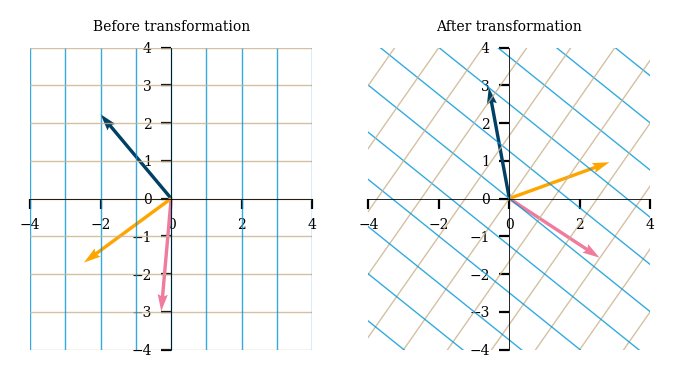

In [ ]:
plot_linear_transformation(orthogonal_matrix, 3*x1, 3*x2, 3*x3, unit_vector=False)

> 좀 더 확실한 visualization을 위해 임시로 각 vector를 3배 해줬습니다. 눈으로 확인해도, rotation 혹은 reflection 중 한 가지임을 알 수 있습니다. 다양한 random_vector들을 새로 initialize 해서 여러가지 예시에 대해 확인해 보시기 바랍니다.

> 계산을 통해 맞는지 확인해봅시다.

In [ ]:
# x1,x2,  Qx1,Qx2의 내적
x1x2 = x1@x2
Qx1Qx2 = Qx1@Qx2
print(x1x2, Qx1Qx2)

# x2,x3,  Qx2,Qx3의 내적
x2x3 = x2@x3
Qx2Qx3 = Qx2@Qx3
print(x2x3, Qx2Qx3)

# x3,x1,  Qx3,Qx1의 내적
x3x1 = x3@x1
Qx3Qx1 = Qx3@Qx1
print(x3x1, Qx3Qx1)

-0.6782699162669127 -0.6782699162669124
0.13004072633358882 0.13004072633358896
0.6403705841527171 0.6403705841527165


> 실제로도 orthogonal matrix $Q$를 거치기 전과 이후, 내적값이 보존됨을 확인할 수 있습니다.

> 정리하면, $P, P^{-1}, U, V$ 등이 orthogonal matrix일 경우, 이를 rotation, reflection 등으로 해석할 수 있게 됩니다. 더 자세한 내용은, 다음 wiki를 참고하시기 바랍니다 (https://en.wikipedia.org/wiki/Isometry).

> SVD의 경우 eigen decomposition과 다르게 $U, V$를 항상 orthogonal matrix로 잡습니다. 즉 rotation, reflection 등으로 해석할 수 있습니다.

> (주의: 위 설명은 분해하려고 하는 matrix의 모든 성분이 실수일 경우에 해당합니다. 허수 element가 있을 경우, 더 조건이 붙게 됩니다.)

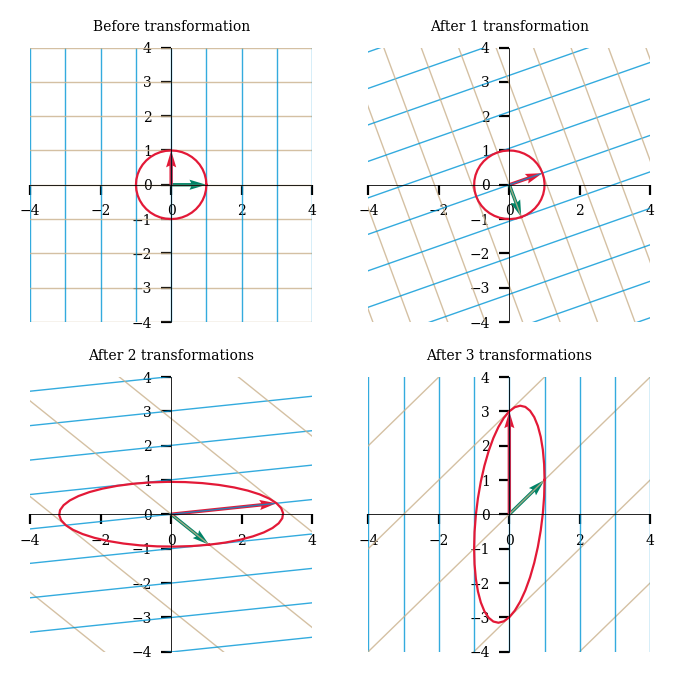

In [ ]:
plot_linear_transformations(VT, S, U, unit_circle=True) # Bx = USVTx

> 맨 처음엔, $V^T$가 unit circle을 회전시키게 됩니다 (After 1 transformation). 그 다음, S는 각 vector의 x축 방향은 $s_1$배, y축 방향은 $s_2$배 하게 됩니다 (After 2 transformations). 마지막으로, $U$가 왼쪽 아래의 ellipse를 다시 회전시키게 됩니다. 이러한 방식으로, SVD를 회전과 scaling의 조합으로 볼 수 있습니다.

# 3. SVD in higher dimensions

> 위에서는 2차원 matrix의 예시를 보았습니다. 3차원 이상의 matrix에서는 어떻게 될지, visualization을 통해 알아보도록 하겠습니다.

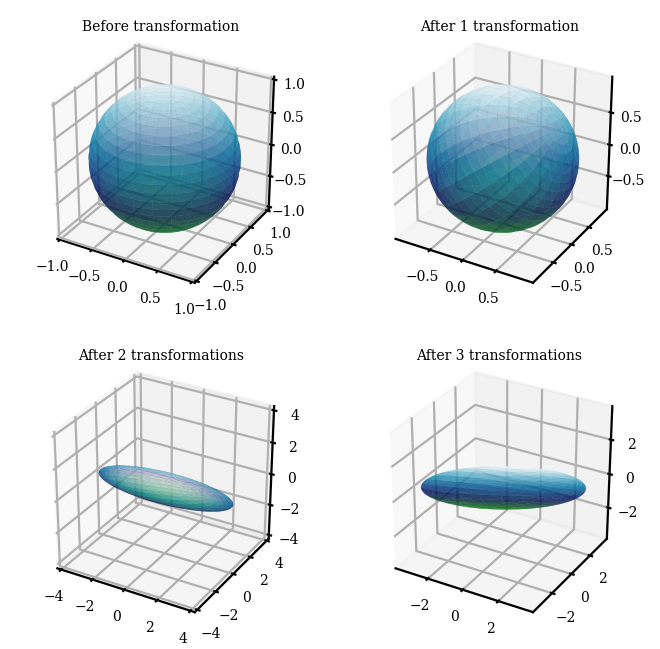

In [ ]:
A = np.array([[1,2,3], [1,1,1], [-1,1,0]])
U, S, VT = np.linalg.svd(A)
plot_3d_linear_transformations(VT, np.diag(S), U, unit_sphere=True)

> Matrix $A$는 rank가 3인, full-rank matrix입니다. 2차원의 예시보다 조금 복잡하긴 하지만, 여전히 '회전-scaling-회전'으로 matrix $A$를 나타낼 수 있음을 알 수 있습니다. 이번엔 다음 행렬을 봅시다.

$$N = \begin{bmatrix} 1 & 2 & 7 \\  0 & 1 & 3 \\    -3 & 1 & 0 \end{bmatrix} $$

> 이 행렬은 rank가 2인 matrix입니다. 즉, column space의 dimension이 2가 됩니다. 이말은 $R^3$ 위의 모든 vector를 전부 $N$에 통과시키면, 나오는 output의 set, 즉 치역이 2차원이라는 말이 됩니다.

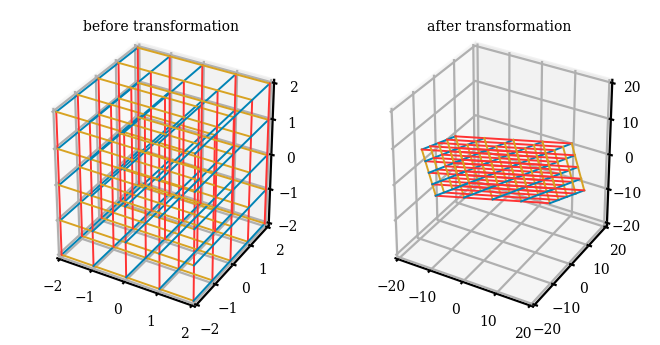

In [ ]:
N = np.array([[1,2,7], [0,1,3], [-3,1,0]])
plot_3d_linear_transformation(N)

> 위와 같은 행렬을, SVD로 분해해서 visualize 해봅시다.

S: [7.99  3.189 0.   ]


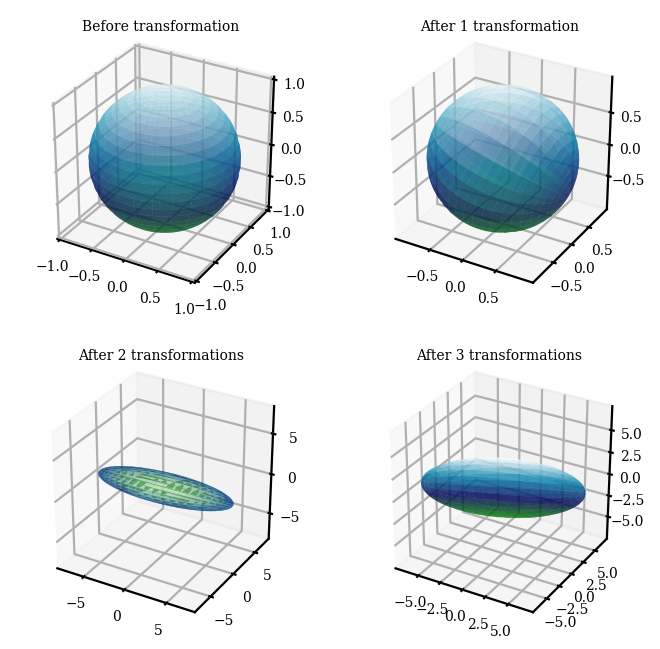

In [ ]:
U, S, VT = numpy.linalg.svd(N)
print('S:',S)
plot_3d_linear_transformations(VT, numpy.diag(S), U, unit_sphere=True)

> 위와 마찬가지로 After 1 transformation에서는 회전이 됨을 알 수 있습니다. After 2 transformations, 즉 scaling도 마찬가지로 작동하는데, matrix $S$의 세 번째 component가 0이기 때문에, 저 도형의 z축 성분이 전부 0이 되게 됩니다. After 3 transformations에서는 z축 성분이 전부 0이 된 도형이 다시 회전됩니다. 결론적으로 전체 $R^3$공간에 2차원 도형이 output으로 나오게 됩니다.

> 이 예시로부터, 0이 아닌 singular value의 개수가, matrix의 rank와 일치함을 알 수 있습니다. 특정 축에 해당하는 singular value가 0일 경우, 위의 After 2 transformations에서처럼 해당 성분이 전부 0이 되어, dimension이 감소할 것이기 때문입니다.

In [ ]:
A = np.array([[1,2,3], [1,1,1], [-1,1,0]])
U, S, VT = np.linalg.svd(A)

print(np.linalg.matrix_rank(A))
print(S)

3
[4.086 1.428 0.514]


In [ ]:
N = np.array([[1,2,7], [0,1,3], [-3,1,0]])
U, S, VT = np.linalg.svd(N)

print(np.linalg.matrix_rank(N))
print(S)

2
[7.99  3.189 0.   ]


> 정리하면, matrix $A$와 같이 $R^{n \times n}$ full-rank matrix의 경우 다음과 같이 표현이 됩니다.

$$
  A =
    \begin{bmatrix}
    \mathbf{u_1} & \mathbf{u_2} & \dots & \mathbf{u_n}
    \end{bmatrix}
    \begin{bmatrix}
    s_1 & & & \\
    & s_2 & & \\
    & & \ddots \\
    & & & s_n
    \end{bmatrix}   
    \begin{bmatrix}
    \mathbf{v_1}^T \\
    \mathbf{v_2}^T \\
    \vdots \\
    \mathbf{v_n}^T
    \end{bmatrix}
$$

> Matrix $N$과 같이 full rank가 아닌 matrix의 경우 다음과 같이 표현이 됩니다 (rank가 k인 경우).

$$
\begin{align*}
  A &=
    \begin{bmatrix}
    \mathbf{u_1} & \mathbf{u_2} & \dots & \mathbf{u_k} & \dots & \mathbf{u_n}
    \end{bmatrix}
    \begin{bmatrix}
    s_1 & & & & & \\
    & s_2 & & & & \\
    & & \ddots & & \\
    & & & s_k & & \\
    & & &  & 0 & \\
    & & & & & \ddots \\
    & & & & & & 0
    \end{bmatrix}    
    \begin{bmatrix}
    \mathbf{v_1}^T \\
    \mathbf{v_2}^T \\
    \vdots \\
    \mathbf{v_k}^T \\
    \vdots \\
    \mathbf{v_n}^T
    \end{bmatrix}
\end{align*}
$$

> 이때, 첫날 배웠던 matrix multiplications as sum of (Rank1) outer product를 생각해본다면, 가운데 $S$ matrix의 $k+1 ~ n$ 부분은 없애버려도 같은 값이 나오게 됩니다.

$$
\begin{align*}
  A &=
    \begin{bmatrix}
    \mathbf{u_1} & \mathbf{u_2} & \dots & \mathbf{u_k}
    \end{bmatrix}
    \begin{bmatrix}
    s_1 & & & \\
    & s_2 & & \\
    & & \ddots \\
    & & & s_k
    \end{bmatrix}   
    \begin{bmatrix}
    \mathbf{v_1}^T \\
    \mathbf{v_2}^T \\
    \vdots \\
    \mathbf{v_k}^T
    \end{bmatrix}
\end{align*}
$$

> 즉 $U,S,V$에서 singular value가 0에 해당하는 부분은 잘라버려도 상관이 없습니다. 위의 $N$을 plot했던 것에서도, 어차피 After 2 transformations에서 0이 되버릴 성분들은, 애초에 VT에서 계산하지 않고 없애버려도 값이 같다는 것입니다.

In [ ]:
U @ np.diag(S) @ VT

array([[ 1.,  2.,  7.],
       [ 0.,  1.,  3.],
       [-3.,  1., -0.]])

In [ ]:
U[:,:2] @ np.diag(S)[:2,:2] @ VT[:2,:]

array([[ 1.,  2.,  7.],
       [ 0.,  1.,  3.],
       [-3.,  1., -0.]])

> 이러한 성질이 low-rank approximation의 motivation이 됩니다. 어떠한 행렬을 저장하고 복원하고 싶을 때, 만약 해당 행렬의 rank가 작다면 (위의 $N$처럼), singular value가 0인 곳은 전부 없애고 나머지만 저장하면 되기 때문에, 더 적은 비용으로 저장 및 복원이 가능한 것입니다.

> 한발 더 나아가, singular value가 0이 아니라, 0에 근접한 매우 작은 값일 때 그냥 0인셈 치고 없애버리면 어떻게 될까요? 당연히 완벽한 저장 및 복원은 불가능할 것입니다. 하지만 퀄리티와 비용의 tradeoff를 생각했을 때, 약간의 퀄리티 손실이 상대적으로 많은 비용의 감소를 가져다 줄 수 있다면, 이를 활용할 수도 있을 것입니다. 이를 활용한 application 중 하나는 압축인데, 실습 뒷부분의 예시에서 보도록 하겠습니다.

## Low rank approximation

> 실제로 real-world application에서 얻어지는 matrix의 경우 full-rank인 경우가 많습니다. 다음 행렬을 보겠습니다.

$$ A = \begin{bmatrix} 1 & 2 & 3 & 6 \\   2 & 5 & 7 & 10 \\    3 & 9 & 12 & 14 \\   4 & 7 & 9 & 15 \end{bmatrix} $$

In [ ]:
A = numpy.array([[1, 2, 3, 6],
                 [2, 5, 7, 10],
                 [3, 9, 12, 14],
                 [4, 7, 9, 15]])
print(numpy.linalg.matrix_rank(A))

4


> 겉으로 볼 땐 평범한 full rank matrix이지만, 이를 SVD해보면 low-rank로 approximate할 여지가 보임을 알 수 있습니다.

In [ ]:
U, S, VT = numpy.linalg.svd(A)
print(U,"\n", np.diag(S),"\n", VT)

[[-0.217  0.43   0.684 -0.548]
 [-0.417  0.051  0.461  0.781]
 [-0.646 -0.703 -0.002 -0.298]
 [-0.601  0.565 -0.565 -0.024]] 
 [[31.945  0.     0.     0.   ]
 [ 0.     2.813  0.     0.   ]
 [ 0.     0.     0.774  0.   ]
 [ 0.     0.     0.     0.058]] 
 [[-0.169 -0.393 -0.524 -0.737]
 [ 0.243 -0.447 -0.605  0.613]
 [-0.856 -0.395  0.209  0.258]
 [ 0.423 -0.7    0.562 -0.123]]


> 상대적으로 마지막 singular value가 0에 가까운데, 이를 무시하고 잘라버리면 어떻게 A가 복원될까요?

In [ ]:
rank_3_approximation = U[:,:3] @ np.diag(S[:3]) @ VT[:3,:]

print(A - rank_3_approximation) # 두 matrix의 차이

[[-0.013  0.022 -0.018  0.004]
 [ 0.019 -0.031  0.025 -0.006]
 [-0.007  0.012 -0.01   0.002]
 [-0.001  0.001 -0.001  0.   ]]


> 가장 작은 singular value를 drop해버려도, 원래 A와 거의 근접한 행렬을 복원할 수 있음을 알 수 있습니다. 만약 훨씬 더 고차원인 행렬에서, 90퍼센트의 singular value가 매우 작다면, 90퍼센트를 잘라버려도 어느 정도 행렬을 approximate 할 수 있을 것이고, 비용 (90퍼센트를 저장하지 않으니까) 은 크게 아낄 수 있을 것입니다.

# 4. Image compression

> Low-rank approximation은 데이터 압축에 자주 사용됩니다. Image를 실제로 압축해보고 이를 visualize 해봅시다.

In [ ]:
from imageio import imread
image = imread('https://github.com/engineersCode/EngComp4_landlinear/blob/master/images/washington-monument.jpg?raw=true')

> 위 image는 numpy.ndarry 형태로 받아집니다.

In [ ]:
print(type(image))
print(image.shape)
print(image.dtype)

<class 'imageio.core.util.Array'>
(300, 300)
uint8


> 이 image는 300 x 300 array인데, 각각의 entry는 0 (검은색) 부터 255 (흰색) 까지 사이의 색을 나타냅니다.

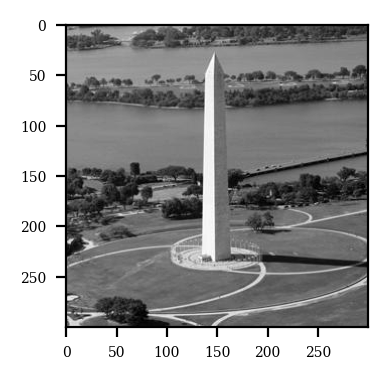

In [ ]:
pyplot.figure(figsize=(2,2))
pyplot.imshow(image, cmap='gray')

> 위 행렬 (300 x 300)의 SVD를 구해봅시다

In [ ]:
U, S, VT = np.linalg.svd(image)
print(U.shape, S.shape, VT.shape) # SVD하면 U는 col, S is matrix, VT is row

(300, 300) (300,) (300, 300)


In [ ]:
VT

Array([[-0.057, -0.057, -0.057, ..., -0.051, -0.051, -0.051],
       [ 0.061,  0.061,  0.071, ...,  0.003,  0.002,  0.004],
       [ 0.003,  0.003,  0.01 , ...,  0.06 ,  0.053,  0.05 ],
       ...,
       [ 0.021, -0.023, -0.014, ..., -0.031,  0.033, -0.019],
       [ 0.041, -0.091,  0.116, ...,  0.021, -0.024,  0.017],
       [ 0.009,  0.002, -0.038, ...,  0.016, -0.015,  0.01 ]])

> 이 이미지를 압축하기 위해, 300개의 singular value를 파악해 봅시다.

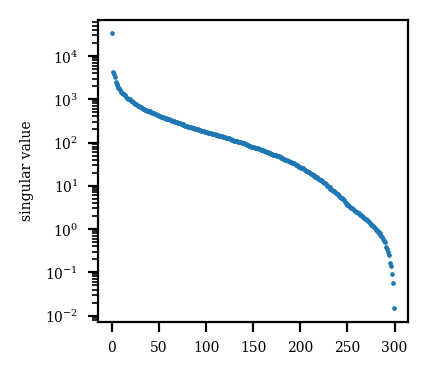

In [ ]:
pyplot.figure(figsize=(2,2))
pyplot.scatter(numpy.arange(len(S)), S, s=0.5)
pyplot.yscale('log')
pyplot.ylabel('singular value');

> 이 image는 90,000개의 integer로 표현되고 있습니다. 만약 우리가 rank-k approximation을 수행한다면, $U$는 300k개, $V$도 300k개, $S$는 k개의 integer만 저장하면 될 것입니다. 그렇다면 압축률은

$$\text{compression ratio} = \frac{300^2}{300k+k+300k}$$

> 가 됩니다. 90,000/601 = 149.7504 이므로, k가 149 이하여야 실제로 compression의 효과를 갖게 됩니다 (k가 150 이상일 경우 오히려 용량이 커지게 됩니다).

> k를 1~149까지 바꿔보면서, 저장 용량과 image quality간의 tradeoff를 visualize 해봅시다.

In [ ]:
from ipywidgets import widgets, fixed
k_slider = widgets.IntSlider(min=1, max=149, step=5)
display(k_slider)

IntSlider(value=1, max=149, min=1, step=5)

> 위 widgets.IntSlider를 이용하면, 1~149까지 k를 5 단위로 바꿔가면서 이를 display 할 수 있게 됩니다.

> 이미지를 위 widget의 k에 맞춰서 dynamic하게 rendering 하려면, widgets.interact()를 사용하면 됩니다. 위 widget.IntSlider로 k를 변경할 때 마다, plot function이 새로 실행되게 됩니다.

> 아래의 approximate()는 widgets.interact()에 사용하기 위한, low-rank approximation 함수입니다.

In [ ]:
def approximate(k, u, s, vt, image):

    # k개의 singular value만 남긴 U,S,V
    u_k = u[:,:k]
    s_k = s[:k]
    vt_k = vt[:k,:]
    copy = numpy.round(u_k @ numpy.diag(s_k) @ vt_k)

    # low-rank matrix와 원래 행렬과의 차이
    diff = image - copy

    fig = pyplot.figure(figsize=(4,2))
    ax1 = pyplot.subplot(121)
    ax1.imshow(copy, cmap='gray')
    ax1.set_title('compressed image'.format(k))
    ax2 = pyplot.subplot(122)
    ax2.imshow(image, cmap='gray')
    ax2.set_title('original image'.format(k))

    # 압축률
    ratio = image.size / (u_k.size + s_k.size + vt_k.size)
    norm = numpy.linalg.norm(diff)
    pyplot.subplots_adjust(top=0.85)
    fig.suptitle('$k = {}$, compression ratio = {:.2f}, norm = {:.2f}'
                 .format(k, ratio, norm), fontsize=5)

In [ ]:
widgets.interact(approximate, k=k_slider, u=fixed(U),
                 s=fixed(S), vt=fixed(VT), image=fixed(image));

interactive(children=(IntSlider(value=41, description='k', max=149, min=1, step=5), Output()), _dom_classes=('…

> k의 값을 바꿔가면서 실행해봅시다. k가 낮아질수록 압축률은 높아지지만, image의 quality가 낮아짐을 알 수 있습니다.

# 5. Nonsquare matrix

> 지금까지는 square matrix에 대해서만 SVD를 해봤습니다. 사실 강의에서 배웠듯, SVD는 eigendecomposition과는 다르게 general한 m x n matrix에 대해서 적용 가능한 decomposition입니다. 다음 행렬에 대해 SVD를 해봅시다.

$$C =  \begin{bmatrix} 1 & 0 \\ 1 & 1 \\ 2 & 3\end{bmatrix}$$

In [ ]:
C = np.array([[1,0],[1,1],[2,3]])
U, S, VT = np.linalg.svd(C)
print('U:', U)
print('\nS:', S)
print('\nVT: ', VT)

U: [[-0.154  0.941  0.302]
 [-0.358  0.231 -0.905]
 [-0.921 -0.247  0.302]]

S: [3.909 0.848]

VT:  [[-0.602 -0.798]
 [ 0.798 -0.602]]


> Linear transformation에서 배웠듯, 위의 $C$는 2차원 vector를 3차원 vector로 옮기는 linear transformation을 나타냅니다.

$$ C= USV^T \\ C = \begin{bmatrix} -0.154 & 0.941 & 0.302 \\
 -0.358 &  0.231 & -0.905 \\ -0.921 & -0.247 &  0.302 \end{bmatrix}
 \begin{bmatrix} 3.909 & 0 \\ 0 & 0.848 \\ 0 & 0 \end{bmatrix}
 \begin{bmatrix} -0.602 & -0.798 \\ 0.798 & -0.602 \end{bmatrix}
 $$

> 실제로 $v_1$이 $u_1$의 상수배, $v_2$가 $u_2$의 상수배로 transform 되고 있는지 봅시다.

In [ ]:
# Cv1
Cv1 = C@VT[0]
# sigma1 * u1
sigma_u1 = 3.909 * U[:,0]
print(Cv1, sigma_u1)

# Cv2
Cv2 = C@VT[1]
# sigma2 * u2
sigma_u2 = 0.848 * U[:,1]
print(Cv2, sigma_u2)

[-0.602 -1.401 -3.599] [-0.602 -1.401 -3.599]
[ 0.798  0.196 -0.21 ] [ 0.798  0.196 -0.21 ]


> $U$의 왼쪽 두 개의 column vector는 예상한 대로 $V$의 column vector의 상수배임을 확인했습니다. 그럼 $U$의 가장 오른쪽 column vector는 어떻게 결정된 것일까요?

> SVD는 $U$와 $V$가 orthogonal matrix가 되야 합니다. $C$의 경우, $S$와 $V$가 정해지면 자동으로 $U$의 왼쪽 두 vector는 정해진 상태입니다. 그렇다면, $U$의 가장 오른쪽 column vector는, 왼쪽 두 vector에 모두 수직한 vector로 잡으면 됩니다. 3차원 공간에서 나머지 두 vector에 수직한 vector는 어떻게 잡을 수 있을까요? 바로 [HW8] Practice_4에서 구현했던 Gram-Schimidt를 사용하면 됩니다. Gram-Schmidt에서 주어진 3개의 수직하지 않은 vector를 서로 수직한 3개의 vector로 바꾼 것처럼, (i) U의 왼쪽 두 column vector $\begin{bmatrix} -0.154 \\ -0.358 \\ -0.921 \end{bmatrix}, \begin{bmatrix} 0.941 \\ 0.231 \\ -0.921 \end{bmatrix}$와 linearly independent한 vector를 아무거나 잡은 다음 (그래야 세 vector가 $R^3$ 전체를 span하기 때문) , (ii) Gram-Schmidt를 사용해서 이 vector를 나머지 두 vector와도 수직하게 바꾸면 됩니다. 실제로 그렇게 구할 경우 $U$의 가장 오른쪽 vector가 나오는지 확인해봅시다.

In [ ]:
# Q의 왼쪽 두 vector와 linearly independent한 vector
u3 = np.array([1,0,0])

# U[:,0], U[;,1], u3으로 이루어진 matrix
new_U = np.hstack((U[:,:2], np.array([[1],[0],[0]])))
print(new_U)

# QR decomposition을 이용
Q, R = np.linalg.qr(new_U)
print(Q)

[[-0.154  0.941  1.   ]
 [-0.358  0.231  0.   ]
 [-0.921 -0.247  0.   ]]
[[-0.154  0.941  0.302]
 [-0.358  0.231 -0.905]
 [-0.921 -0.247  0.302]]


> Q의 가장 오른쪽 column $\begin{bmatrix} 0.302 \\ -0.905 \\ 0.302 \end{bmatrix}$가  SVD로 구한 $U$의 오른쪽 column vector와 일치함을 알 수 있습니다.

> 위와 같은 방식으로, non-square matrix에 대해서도 SVD를 구할 수 있습니다.

# Reference

1. https://github.com/jclosure/EngComp4_landlinear